In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mne

# Initializing Global Variables

In [3]:
delta = 20
beta = 30
window_len = 10

In [6]:
import os


high_ahi_path = "/content/drive/MyDrive/SleepApnea/Data/High_AHI"
low_ahi_path = "/content/drive/MyDrive/SleepApnea/Data/Low_AHI"

one_patient_txt = os.path.join(high_ahi_path, 'OSAA10002 epoch and event list.txt')
one_patient_edf = os.path.join(high_ahi_path, 'OSAA10002_New.edf')

## Creating and Labelling Windows based on 6 cases described in the image. 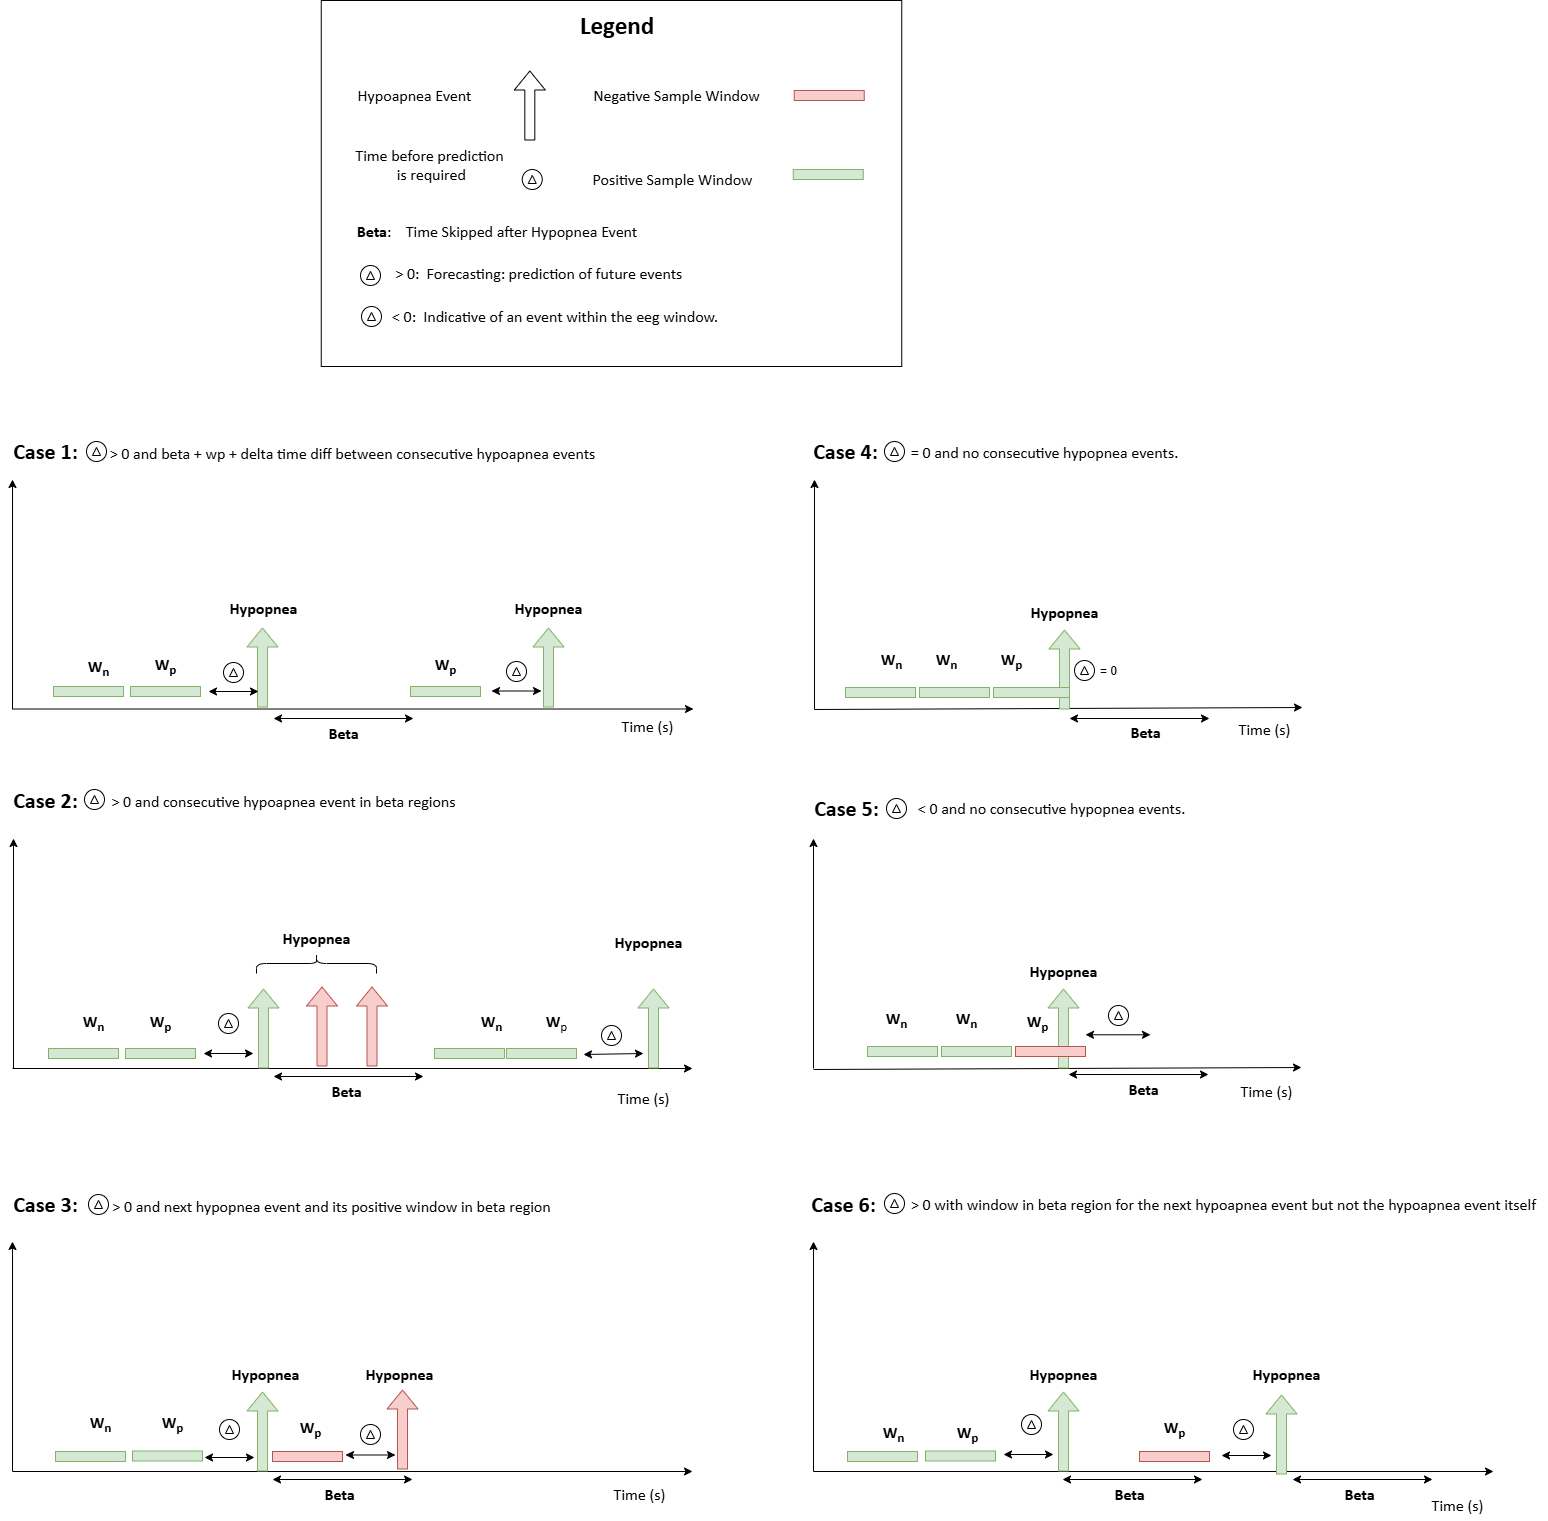

In [10]:
import mne

raw = mne.io.read_raw_edf(one_patient_edf, preload=True, verbose=False)
edf_start = raw.info['meas_date'].replace(tzinfo=None)  # Remove timezone

In [11]:
import os
import pandas as pd
import mne
from datetime import datetime, timedelta

def read_events(txt_path, start_line=13):
    """
    Read a PSG .txt event file and return a DataFrame with:
      - 'Event'
      - 'Start Time' (as datetime)
      - 'seconds_since_start' (float)
    """

    # read all lines to extract the recording start time
    with open(txt_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()
        txt_start_line = lines[4].strip().split('\t')[1]
        txt_start = datetime.strptime(txt_start_line, "%Y-%m-%d %I:%M:%S %p")

        data = [line.strip().split('\t') for line in lines[start_line:] if line.strip()]
        df = pd.DataFrame(data)
        df.columns = df.iloc[0]
        df = df[1:].reset_index(drop=True)

    df['time_only'] = pd.to_datetime(df['Start Time'], format="%I:%M:%S %p", errors='coerce').dt.time
    df['Start Time'] = df['time_only'].apply(lambda t: datetime.combine(edf_start.date(), t))
    df.loc[df['Start Time'] < edf_start, 'Start Time'] += timedelta(days=1)

    df['seconds_since_start'] = (df['Start Time'] - edf_start).dt.total_seconds()

    return df


In [12]:
def make_sample_windows(events_df,
                        window_length: float = 10.0,
                        delta: float = 20.0,
                        beta: float = 0.0):
    """
    From an events DataFrame, build non-overlapping 10 s windows for each hypopnea:
      - A 'pos' window: the 10 s block ending delta seconds before the hypopnea onset.
      - A 'neg' window: the 10 s block immediately before the 'pos' window.
    Any hypopnea whose onset occurs within beta seconds of the last kept
    hypopnea will be skipped entirely (no windows).
    Windows that overlap any previously accepted window are also dropped.

    Returns a DataFrame with columns:
      ['event_time', 'label', 'start', 'end']
    """
    # get sorted hypopnea onset times
    hypos = (
        events_df.query("Event.str.contains('Hypopnea', na=False)")
        .seconds_since_start
        .sort_values()
        .to_numpy()
    )

    accepted = []   # list of (start, end) for windows we've kept
    samples  = []   # dicts of window info
    skip_until = -float('inf')

    for t in hypos:
        # enforce the refractory beta period
        if t < skip_until:
            continue

        # define candidate windows
        pos_end   = t - delta
        pos_start = pos_end   - window_length
        neg_end   = pos_start
        neg_start = neg_end   - window_length

        candidates = []
        if delta < 0:
            candidates.append(('neg', neg_start, neg_end))
        else:
            candidates.extend([
                ('neg', neg_start, neg_end),
                ('pos', pos_start, pos_end),
            ])

        # check each candidate for overlap with any accepted window
        keep = []
        for label, st, en in candidates:
            if st < 0:
                continue
            overlap = any(not (en <= a_st or st >= a_en)
                          for a_st, a_en in accepted)
            if not overlap:
                keep.append((label, st, en))

        # record surviving windows and update accepted list
        if keep:
            for label, st, en in keep:
                samples.append({
                    'event_time': t,
                    'label':       label,
                    'start':       st,
                    'end':         en
                })
                accepted.append((st, en))
            # after taking these windows, enforce beta
            skip_until = t + beta

    return pd.DataFrame(samples)




In [13]:
def extract_from_edf(edf_path, windows_df, preload=True):
    """
    Given an EDF file and a windows DataFrame (with 'start'/'end' in seconds),
    load the raw signals once and slice out each window. Returns a list of dicts:
      [{'data': np.ndarray, 'times': np.ndarray, 'label': str}, ...]
    """
    raw = mne.io.read_raw_edf(edf_path, preload=preload, verbose=False)
    sfreq = raw.info['sfreq']
    out = []
    for _, row in windows_df.iterrows():
        start_samp = int(row.start * sfreq)
        end_samp   = int(row.end   * sfreq)
        data, times = raw[:, start_samp:end_samp]
        out.append({
            'data':  data,
            'times': times,
            'label': row.label
        })
    return out



In [14]:


# === User parameters ===
txt_file    = one_patient_txt
edf_file    = one_patient_edf

# === Pipeline ===
events = read_events(txt_file)
windows = make_sample_windows(events,
                              window_length=window_len,
                              delta=delta,
                              beta=beta)
print("Generated windows:")
print(windows)

windows.to_csv('windows.csv', index=False)
# Optional: extract the raw signal for each window
# samples = extract_from_edf(edf_file, windows)
# print(f"Extracted {len(samples)} signal segments.")

Generated windows:
     event_time label    start      end
0        2649.0   neg   2609.0   2619.0
1        2649.0   pos   2619.0   2629.0
2        9158.0   neg   9118.0   9128.0
3        9158.0   pos   9128.0   9138.0
4        9234.0   neg   9194.0   9204.0
..          ...   ...      ...      ...
105     26416.0   pos  26386.0  26396.0
106     26449.0   neg  26409.0  26419.0
107     26449.0   pos  26419.0  26429.0
108     26560.0   neg  26520.0  26530.0
109     26560.0   pos  26530.0  26540.0

[110 rows x 4 columns]


## Extracting Hypopnea events from events.txt

In [15]:
def get_hypopnea_events(df, out_csv=None):
    dur_cols = [c for c in df.columns if 'duration' in c.lower()]
    if not dur_cols:
        raise KeyError("Could not find any column containing 'duration'.")
    duration_col = dur_cols[0]

    # 5) Filter for Hypopnea events
    mask = df['Event'].str.contains('Hypopnea', na=False, case=False)
    df_hypo = df.loc[mask, ['Event', 'Start Time', 'seconds_since_start', duration_col]].copy()
    df_hypo.rename(columns={duration_col: 'Duration'}, inplace=True)

    # 6) Print to console
    print("\nAll Hypopnea events:")
    print(df_hypo.to_string(index=False))

    # 7) Optionally write to CSV
    if out_csv:
        df_hypo.to_csv(out_csv, index=False)
        print(f"\nSaved to {out_csv!r}")

    return df_hypo


In [16]:
events = read_events(txt_file)

In [17]:
df_hypo = get_hypopnea_events(events, out_csv='hypopnea_events.csv')


All Hypopnea events:
              Event          Start Time  seconds_since_start Duration
Hypopnea w/ Arousal 2016-08-15 22:59:02               2649.0    24.47
Hypopnea w/ Arousal 2016-08-16 00:47:31               9158.0    14.32
Hypopnea w/ Arousal 2016-08-16 00:48:47               9234.0     9.28
Hypopnea w/ Arousal 2016-08-16 00:49:24               9271.0    13.80
Hypopnea w/ Arousal 2016-08-16 00:50:29               9336.0    13.39
Hypopnea w/ Arousal 2016-08-16 01:59:52              13499.0    12.64
           Hypopnea 2016-08-16 02:01:41              13608.0    20.96
           Hypopnea 2016-08-16 02:14:36              14383.0    11.12
           Hypopnea 2016-08-16 02:15:09              14416.0    37.23
Hypopnea w/ Arousal 2016-08-16 02:38:26              15813.0    28.65
           Hypopnea 2016-08-16 02:39:30              15877.0    20.29
           Hypopnea 2016-08-16 02:48:58              16445.0    20.13
           Hypopnea 2016-08-16 02:50:01              16508.0    18.9

## Checking correctness of output file with labels against the events.txt

In [18]:
import pandas as pd
import numpy as np

def load_hypopnea_times(csv_path: str,
                        event_col: str = 'Event',
                        time_col:  str = 'seconds_since_start') -> np.ndarray:
    """
    Load and return a sorted array of unique hypopnea onset times (in seconds)
    from a CSV that has an 'Event' column and a seconds‐since‐start column.
    """
    df = pd.read_csv(csv_path)
    mask = df[event_col].str.contains('Hypopnea', case=False, na=False)
    return np.sort(df.loc[mask, time_col]
                   .dropna()
                   .unique())

def load_window_times(csv_path: str,
                      time_col:  str = 'event_time') -> np.ndarray:
    """
    Load and return a sorted array of unique event_time values
    from your windows CSV.
    """
    df = pd.read_csv(csv_path)
    return np.sort(df[time_col]
                   .dropna()
                   .unique())

def compare_onsets(hypo_times:   np.ndarray,
                   window_times: np.ndarray,
                   tol:          float     = 1e-3) -> tuple[list, list]:
    """
    Compare two arrays of times. Returns:
      - missing: hypopnea times not found in window_times (within ±tol)
      - extra:   window_times not found in hypo_times (within ±tol)
    """
    missing = [t for t in hypo_times
               if not np.any(np.isclose(window_times, t, atol=tol))]
    extra   = [t for t in window_times
               if not np.any(np.isclose(hypo_times, t, atol=tol))]
    return missing, extra

def check_refractory(missing:       list,
                     hypo_times:    np.ndarray,
                     beta:          float) -> tuple[list, list]:
    """
    Of the missing hypopnea onsets, separate those that are within `beta`
    seconds of a previous hypopnea (i.e., explained by the refractory rule)
    from those that are not.

    Returns:
      - explained:   missing times that have a hypo < beta seconds before
      - unexplained: missing times with no prior hypo in the last beta sec
    """
    explained   = []
    unexplained = []
    for t in missing:
        # find any earlier hypo within beta seconds
        prev = hypo_times[hypo_times < t]
        if prev.size and (t - prev.max()) <= beta:
            explained.append(t)
        else:
            unexplained.append(t)
    return explained, unexplained

In [19]:
# === User parameters ===
hypo_csv    = 'hypopnea_events.csv'  # all events with seconds_since_start
windows_csv = 'windows.csv'          # your generated windows with event_time
tol         = 0.01                   # match tolerance in seconds

# === Load data ===
hypo_times   = load_hypopnea_times(hypo_csv)
window_times = load_window_times(windows_csv)

# === Compare onsets ===
missing, extra = compare_onsets(hypo_times, window_times, tol=tol)

# === Check refractory explanation ===
explained, unexplained = check_refractory(missing, hypo_times, beta)

# === Reporting ===
if not missing:
    print("All hypopnea onsets covered in windows.")
else:
    print("Missing hypopnea onsets:")
    for t in missing:
        print(f"  {t:.3f}s")
    if explained:
        print("\n  Explained by refractory (within β seconds of prior event):")
        for t in explained:
            print(f"  {t:.3f}s")
    if unexplained:
        print("\n  Unexplained missing onsets (no prior hypo in last β sec):")
        for t in unexplained:
            print(f"  {t:.3f}s")

if not extra:
    print("\n No extra event_time entries in windows.")
else:
    print("\n  Window entries without matching hypopnea:")
    for t in extra:
        print(f" {t:.3f}s")

Missing hypopnea onsets:
  21656.000s
  24217.000s

  Explained by refractory (within β seconds of prior event):
  21656.000s
  24217.000s

 No extra event_time entries in windows.
